In [1]:
#####################################################################

#####################     Dependencies      #########################

#####################################################################

# This project is done by Python 3 kernel.

from matplotlib import pyplot as plt
import json
from collections import Counter
from datetime import datetime
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime
import warnings
import nltk
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import *
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score
from sklearn.svm import SVC

%matplotlib notebook
warnings.filterwarnings('ignore')

In [2]:
def getCityStarCount(city_name):
    """
    This function returns a dataframe that contains a column including frequencies for each star 
    categories (therefore 5 columns), a column including the total frequency for all 5 star categories, and a column
    including the city name.
    """
    
    try:
        city_business_df = business[business["city"].isin([city_name])]
        city_business_id = list(city_business_df.business_id)
        count_dict = dict(Counter(reviews[reviews["business_id"].isin(city_business_id)]["stars"]))
        total = sum(count_dict.values())
        city_star_count_df = pd.DataFrame(count_dict, columns = count_dict.keys(), index = [0])
        city_star_count_df.columns = ["OneStar", "TwoStar", "ThreeStar", "FourStar", "FiveStar"]
        city_star_count_df["CityName"] = city_name
        city_star_count_df["Total"] = total
    except ValueError:
        pass
    
    return city_star_count_df

In [3]:
def lowercase_remove_punctuation_and_tokenize(s):
    """
    This function returns the list of tokens that is not in the stop words list.
    """
    
    s = s.lower()
    translator = str.maketrans('', '', string.punctuation)
    s = s.translate(translator)
    token_list = nltk.word_tokenize(s)
    filtered = [w for w in token_list if not w in stopwords.words('english')]
    return filtered

In [4]:
def getWordLen(user_review):
    """
    This function returns a dataframe of a column containing the number of good words, a column containing the number
    of bad words, and a column containing the number of words.
    """
    
    user_star = user_review.stars
    review_useful = user_review.useful
    tok_list = lowercase_remove_punctuation_and_tokenize(user_review.text)
    review_len = len(tok_list)
    good_words_len = len([word for word in tok_list if word in positive_words])
    bad_words_len = len([word for word in tok_list if word in negative_words])
    reviews_len_df = pd.DataFrame({"GoodWordsLen": good_words_len, "BadWordsLen": bad_words_len, 
                                   "ReviewLen": review_len, "Useful": review_useful}, 
                                  index = [0])
    return reviews_len_df

In [5]:
def make_confusion_matrix_relative(confusion_matrix):
    """
    This function converts the entires of the confusion matrix to relative frequencies.
    """
    
    star_category_classes = [1, 2, 3, 4, 5]
    N = list(map(lambda clazz : sum(test_y == clazz), star_category_classes))
    relative_confusion_matrix = np.empty((len(star_category_classes), len(star_category_classes)))
    
    for j in range(len(star_category_classes)):
        if N[j] > 0:
            relative_frequency = confusion_matrix[j, :] / float(N[j])
            relative_confusion_matrix[j, :] = relative_frequency
            
    return relative_confusion_matrix

In [6]:
# Code courtecy:
# http://www.wenda.io/questions/4330313/heatmap-with-text-in-each-cell-with-matplotlibs-pyplot.html
# http://stackoverflow.com/questions/20520246/create-heatmap-using-pandas-timeseries
# http://sebastianraschka.com/Articles/heatmaps_in_r.html
# http://code.activestate.com/recipes/578175-hierarchical-clustering-heatmap-python/
def plot_confusion_matrix(confusion_matrix=[[]], title = 'CM', savefilename = ''):
    """
    This function plots the relative confusion matrix.
    """
    
    rcm = make_confusion_matrix_relative(confusion_matrix)
    #plt.imshow(rcm, vmin=0, vmax=1, interpolation='nearest')
    c = plt.pcolor(rcm, edgecolors = 'k', linewidths = 4, cmap = 'jet', vmin = 0.0, vmax = 1.0)
    plt.title(title)
    plt.colorbar()
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(0.5 + np.arange(5), np.arange(1, 6))
    plt.yticks(0.5 + np.arange(5), np.arange(1, 6))

    def show_values(pc, fmt = "%.2f", **kw):
        import itertools
        pc.update_scalarmappable()
        ax = pc.get_axes()
        for p, color, value in zip(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if sum(color[:2] > 0.3) >= 2:
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha = "center", va = "center", color = color, **kw)
    
    show_values(c)

    if savefilename:
        plt.savefig(savefilename, bbox_inches = 'tight')
    
    return plt.show()

In [7]:
def print_classifier_performance_metrics(name, predictions):
    """
    This function returns the output of the performance of the classification method.
    """
    
    target_names = ['1 star', '2 star', '3 star', '4 star', '5 star']
    
    print("MODEL: %s" % name)
    print()

    print('Precision: ' + str(metrics.precision_score(test_y, predictions, average = "macro")))
    print('Recall: ' + str(metrics.recall_score(test_y, predictions, average = None)))
    print('F1: ' + str(metrics.f1_score(test_y, predictions, average = None)))
    print('Accuracy: ' + str(metrics.accuracy_score(test_y, predictions)))

    print()
    print('Classification Report:')
    print(classification_report(test_y, predictions, target_names=target_names))
    
    print()
    print('Precision variance: %f' % np.var(precision_score(test_y, predictions, average=None), 
                                            ddof=len(target_names)-1))
    
    print()
    print('Recall variance: %f' % np.var(recall_score(test_y, predictions, average=None), ddof=len(target_names)-1))

In [8]:
#####################################################################

#####################        Project       ##########################

#####################################################################

# The Yelp Challenge dataset is stored in json format. Load all data.
with open("yelp_academic_dataset_business.json", encoding = "utf8") as f:
     business = f.read().strip().split("\n")
business = [json.loads(i) for i in business]

with open("yelp_academic_dataset_checkin.json", encoding = "utf8") as f:
     checkin = f.read().strip().split("\n")
checkin = [json.loads(i) for i in checkin]

with open("yelp_academic_dataset_user.json", encoding = "utf8") as f:
     users = f.read().strip().split("\n")
users = [json.loads(user) for user in users]

with open("yelp_academic_dataset_tip.json", encoding = "utf8") as f:
     tip = f.read().strip().split("\n")
tip = [json.loads(i) for i in tip]

with open("yelp_academic_dataset_review.json", encoding = "utf8") as f:
     reviews = f.read().strip().split("\n")
reviews = [json.loads(review) for review in reviews]
reviews = pd.DataFrame(reviews)

<IPython.core.display.Javascript object>


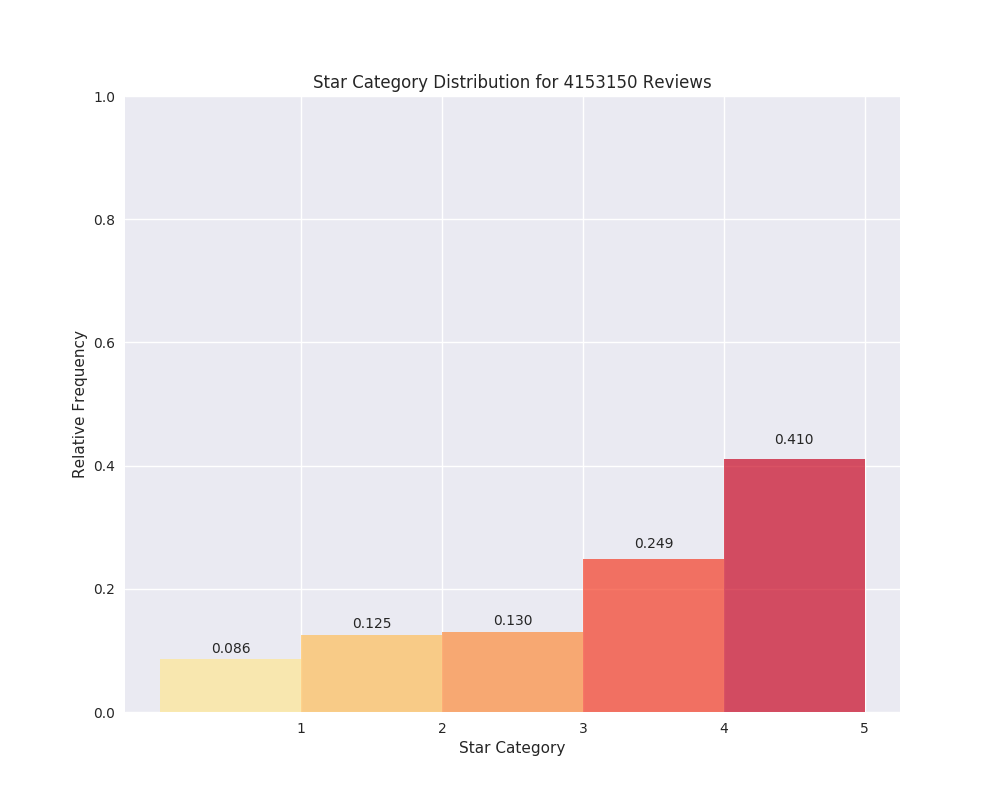

In [9]:
# Plot the star category distribution for all reviews.

N_star_categories = 5
colors = np.array(['#E50029', '#E94E04', '#EEC708', '#A5F30D', '#62F610'])

stars_labels = np.array([x_stars + 1 for x_stars in range(N_star_categories)])
star_category_dist_fig = plt.figure(figsize = (10, 8), dpi = 100)
bar_plot_indices = np.arange(N_star_categories)
star_category_absolute_frequencies = reviews.stars.value_counts(ascending = True)
star_category_relative_frequencies = (np.array(star_category_absolute_frequencies)/
                                      float(sum(star_category_absolute_frequencies)))
rects = (plt.bar(bar_plot_indices, star_category_relative_frequencies, width = 1, 
                 color = sns.color_palette("YlOrRd", 5), alpha = .7))

for (idx, rect) in enumerate(rects):
        plt.gca().text(rect.get_x() + rect.get_width()/2., 1.05*rect.get_height(), 
                       '%.3f'%(star_category_relative_frequencies[idx]), ha = 'center', va = 'bottom')

plt.xticks(bar_plot_indices + .5, stars_labels)
plt.xlabel('Star Category')
plt.ylabel('Relative Frequency')
plt.ylim([0, 1])
plt.title('Star Category Distribution for {0} Reviews'.format(len(reviews)))

plt.show()

<h4>The graph Star Category Distribution shows how ratings are disdributed for each star category.</h4>
<h4>The number of 5-star ratings accounts 41% of the dataset. The 4-star ratings, which account for about 25% of the dataset is the second many ratings given to business. Next are 1-star, 2-star and 3-star ratings, each of which accounts 8.6%, 12.5%, and 13% of the dataset, respectively. Give the information of the above graph, this dataset is extremely skewed to the left. Normally 4-star and 5-star ratings are perceived as good ratings to a business. Together good ratings account for 66% of the entire dataset, showing that people tend to give out high ratings to business.</h4>
<h4>The gap between 4-star ratings and 5-star ratings is significant, showing that the emotional difference between a 4-star and a 5-star is obvious. The gap between 3-star ratings and 4-star ratings is significant, showing that the emotional difference between so-so and good is obvious. However, the gaps among 1-star, 2-star and 3-star ratings are dim, showing that people tend to perceive bad emotions more uniformly.</h4>

In [10]:
business = pd.DataFrame(business)

# The major cities are obtained from the description on the Yelp challenge dataset website.
main_city = (["Edinburgh", "Karlsruhe", "Montreal", 
              "Waterloo", "Pittsburgh", "Charlotte", "Urbana", "Phoenix", "Las Vegas", "Madison", "Cleveland"])

city_star_count_df = pd.DataFrame()
for i in main_city:
    city_star_count_df = city_star_count_df.append(getCityStarCount(i), ignore_index = True)

city_star_count_df = city_star_count_df.dropna()
city_star_count_df = city_star_count_df.reset_index(drop = True)
city_star_count_df = city_star_count_df.sort_values(by = "Total", ascending = False)

<IPython.core.display.Javascript object>


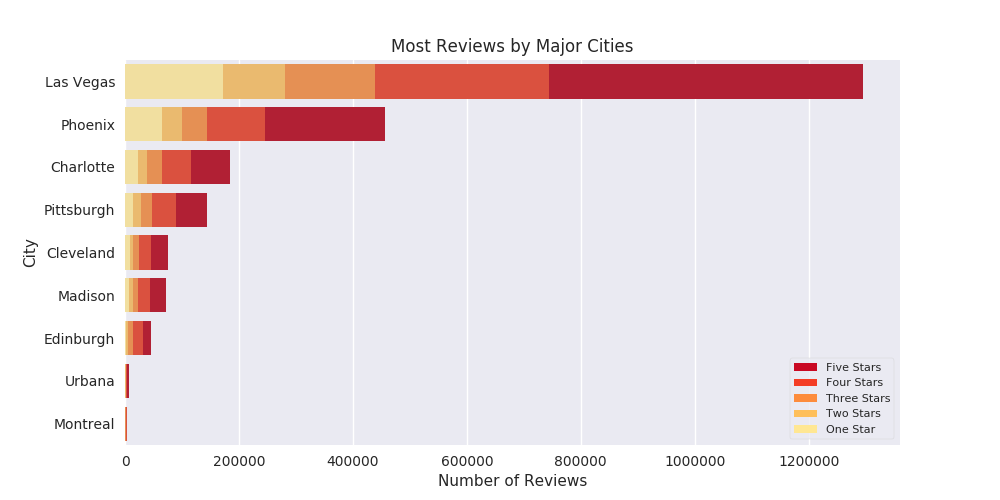

In [11]:
# Plot the number of reviews for each major city.

colors = sns.color_palette("YlOrRd", 5)
colors = colors[::-1]
plt.figure(figsize = (10, 5), dpi = 100)
stars_list = ['FiveStar','FourStar','ThreeStar','TwoStar','OneStar']

sum_val = 0
for i in range(5):
    city_star_count_plot = sns.barplot(x = city_star_count_df.Total - sum_val, 
                                        y = city_star_count_df.CityName, color = colors[i])
    sum_val = sum_val + city_star_count_df[stars_list[i]]

city_star_count_bar = [plt.Rectangle((0, 0), 1, 1, fc = i, edgecolor = 'none') for i in colors]
city_star_count_legend = plt.legend(city_star_count_bar, 
                                     ['Five Stars','Four Stars','Three Stars','Two Stars','One Star'], 
                                     loc = 'lower right', ncol = 1, prop = {'size':8})
city_star_count_legend.draw_frame(True)
city_star_count_plot.set(xlabel = "Number of Reviews", ylabel = "City", title = "Most Reviews by Major Cities")

<h4>The graph Most Reviews by Major Cities shows how star categories are distributed for each city in major cities.</h4>
<h4>Las Vegas receives most reviews among all other cities, and Phoenix receives the second most reviews. Together these two cities account for about 44% of the reveiws in the dataset. Noticeably, how ratings distributed in each city coincides with the graph Star Category Distribution.</h4>

In [12]:
real_name = [str(i) for i in business['name']]

# Find top 10 most business with most comments.
top10 = Counter(reviews['business_id']).most_common(10)
top10_id = list(pd.DataFrame(top10)[0])

top10_star = [Counter(reviews.loc[reviews['business_id']== i]['stars']) for i in top10_id]
top10_star_df = pd.DataFrame(top10_star)
top10_star_df

# Find index for top 10 restaurants.
top10_idx = [business[business['business_id'] == top].index.tolist()[0] for top in top10_id]
top_name = [real_name[i] for i in top10_idx]

# Update the real name.
top10_star_df.columns = ['OneStar','TwoStar','ThreeStar','FourStar','FiveStar']
top10_star_df['name'] = top_name
top10_star_df['total'] = list(pd.DataFrame(top10)[1])

<IPython.core.display.Javascript object>


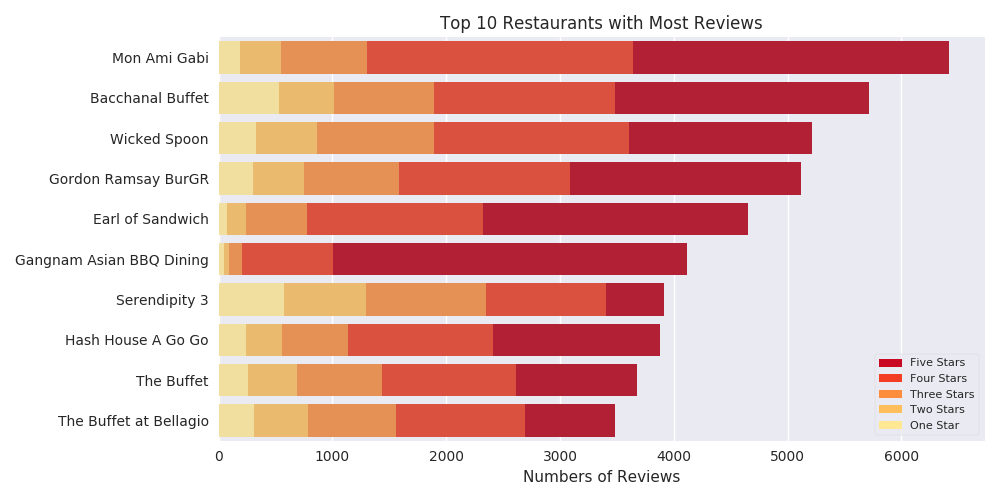

In [13]:
namelist = list(top10_star_df)[:5]
namelist = namelist[::-1]

spec = sns.color_palette("YlOrRd", 5)
spec = spec[::-1]
plt.figure(figsize = (10, 5), dpi = 100)

mysum = 0
for i in range(5):
    myplot = sns.barplot(x = top10_star_df.total - mysum, y = top10_star_df.name, color=spec[i])
    mysum = mysum + top10_star_df[namelist[i]]

    
mybar = [plt.Rectangle((0,0),1,1, fc=i, edgecolor = 'none') for i in spec]
l = plt.legend(mybar, ['Five Stars','Four Stars','Three Stars','Two Stars','One Star'], 
               loc='lower right', ncol = 1, prop={'size':8})
l.draw_frame(True)
myplot.set(xlabel = 'Numbers of Reviews', ylabel = '', title = "Top 10 Restaurants with Most Reviews")
myplot.figure.tight_layout()

<h4>The graph Top 10 Restaurants with Most Reviews shows how star ratings are distributed among top 10 restaurants that receive most reviews.</h4>
<h4>Again, how star ratings distributed for each restaurant coincides with the graph Star Category Distribution. Noticeably, Gangnam Asian BBQ Dining is an outlier. The number of 5-star ratings this restaurant receives accounts for about 75% of the total number of reviews at this restaurant, showing that this restaurant is exceptionally good and popular among all restaurants.</h4>

In [14]:
# Create a list in which each element is of the format weekday-time, e.g. Sun-0.
checkin_time = [l for sublist in (pd.DataFrame(checkin)).time for l in sublist]
checkin_time = [i.split(":")[0] for i in checkin_time]

checkin_time_df = pd.DataFrame.from_dict(Counter(checkin_time), orient = "index").reset_index()

# Create a dataframe where one column is weekday-time and other column is the frequency of that weekday-time.
for i in range(len(checkin_time_df['index'])):
    if (len(checkin_time_df['index'][i]) == 5):
        checkin_time_df['index'][i] = checkin_time_df['index'][i][:4] + '0' + checkin_time_df['index'][i][4:]
checkin_time_df.columns = ['time','freq']

# Change the format weekday-time (e.g. Sun-0) to 0-00 and add this as another column for checkin_time_df.
time_num = [i.replace('Sun','0').replace('Mon','1').replace('Tue','2').replace('Wed','3')
            .replace('Thu','4').replace('Fri','5').replace('Sat','6') for i in checkin_time_df['time']]
checkin_time_df['time_num'] = time_num
checkin_time_df = checkin_time_df.sort_values(by = 'time_num')

<IPython.core.display.Javascript object>


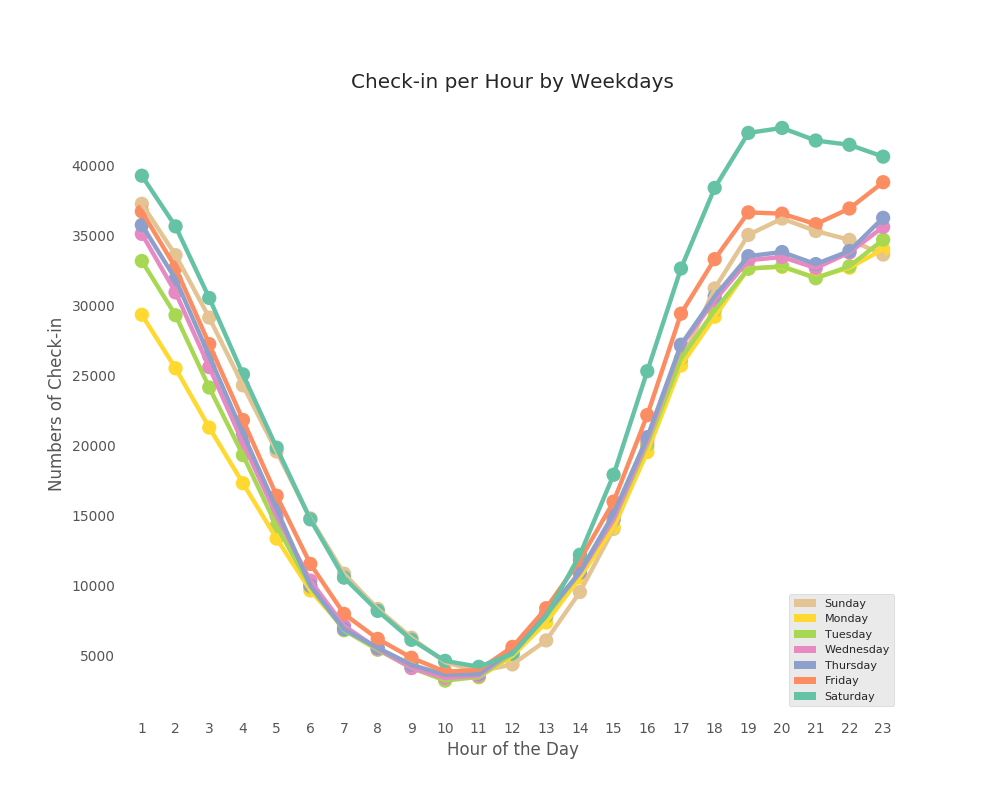

In [23]:
# Plot the checkin number for each hour in a day per week.

plt.figure(figsize = (10, 8), dpi = 100)
plt.style.use('ggplot')
spectrum = sns.color_palette("Set2",7)[::-1]

for i in range(7):
    k = i*24
    checkin_time_plot = sns.pointplot(x = checkin_time_df.time[0 + k: 23 + k], 
                                      y = checkin_time_df.freq[0 + k: 23 + k], color = spectrum[i])

checkin_time_plot.set_xticklabels(list(range(1, 25, 1)))
checkin_time_plot.set(xlabel = 'Hour of the Day', ylabel = 'Numbers of Check-in', 
                      title = 'Check-in per Hour by Weekdays')
checkin_time_plot.set(axis_bgcolor = '#ffffff')

mybar = [plt.Rectangle((0, 0), 1, 1, fc = i, edgecolor = 'none') for i in spectrum]
l = plt.legend(mybar, ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', "Friday", "Saturday"], 
               loc = 'lower right', ncol = 1, prop={'size':8})
l.draw_frame(True)

<h4>The Check-in per Hour by Weekdays graph shows the number of checkins every hour in a day per week.</h4> 
<h4>The trend of number of checkins for each hour has the following pattern: it starts high, then goes down to a bottom at around 10:00 AM, and rebounds to day-high at around 20:00-21:00. The peak of the number of checkins occurs between 20:00 and 1:00. Before 20:00, the number of checkins is in an upward trend, and after 1:00 the number of checkins is in a downward trend. This phenomenon happens because during 20:00 and 1:00, people tend to go out to have dinner or to hang out for leisure. Such activities tend to begin at around 20:00 and end at aroung 1:00. The bottom of the number of checkins occurs at 10:00-11:00. During this time period, people are normally at work, and surely workplace is not suitable for checkins.</h4>
<h4>Among the days in a week, Saturday and Sunday have substantialy higher numbers of checkins in each hour. Moreover, Saturday has even more number of checkins in each hour than has Sunday. It is understandable bacause Saturday is the first day of weekend and people will have the right mood for entertainment, while Sunday can usually be perceived as the preparation for the upcoming week, and therefore the number of checkins, compared to that of Saturday, decreases.</h4>

In [16]:
city_business_df = business[business["city"].isin(main_city)]
business_id_list = list(city_business_df.business_id)

reduced_reviews = reviews[["business_id", "text", "useful"]]

reduced_business = business[["business_id", "city", "review_count", "stars"]]
reduced_business = reduced_business[reduced_business["city"].isin(main_city)]

new_reviews = pd.merge(reduced_reviews, reduced_business, on = "business_id")
random.seed(88)

In [17]:
one_star_reviews = new_reviews[new_reviews["stars"] == 1]
two_star_reviews = new_reviews[new_reviews["stars"] == 2]
three_star_reviews = new_reviews[new_reviews["stars"] == 3]
four_star_reviews = new_reviews[new_reviews["stars"] == 4]
five_star_reviews = new_reviews[new_reviews["stars"] == 5]

one_star_idx = random.sample(range(len(one_star_reviews)), k = 2000)
two_star_idx = random.sample(range(len(two_star_reviews)), k = 2000)
three_star_idx = random.sample(range(len(three_star_reviews)), k = 2000)
four_star_idx = random.sample(range(len(four_star_reviews)), k = 2000)
five_star_idx = random.sample(range(len(five_star_reviews)), k = 2000)

one_star_reviews = one_star_reviews.iloc[one_star_idx]
two_star_reviews = two_star_reviews.iloc[two_star_idx]
three_star_reviews = three_star_reviews.iloc[three_star_idx] 
four_star_reviews = four_star_reviews.iloc[four_star_idx]
five_star_reviews = five_star_reviews.iloc[five_star_idx]

business_star_reviews = pd.concat([one_star_reviews, 
                                   two_star_reviews, three_star_reviews, four_star_reviews, five_star_reviews])
business_star_reviews.reset_index(drop = True, inplace = True)

In [18]:
train_x, test_x, train_y, test_y = train_test_split(business_star_reviews.text, business_star_reviews.stars, 
                                                   test_size = 0.2, random_state = 4)

<IPython.core.display.Javascript object>


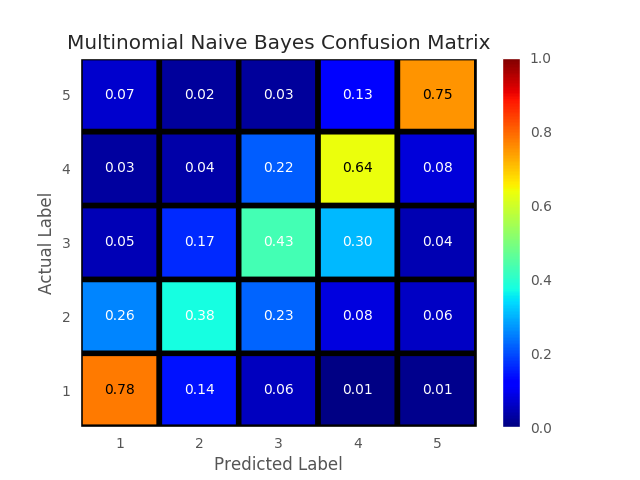

In [24]:
bag_of_words_vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, 
                                          ngram_range = (1, 1), binary = False, strip_accents = 'unicode')
bow_feature_matrix_train = bag_of_words_vectorizer.fit_transform(train_x)
bow_feature_matrix_test = bag_of_words_vectorizer.transform(test_x)
multinomial_nb_classifier = MultinomialNB()
multinomial_nb_classifier.fit(bow_feature_matrix_train, train_y)
multinomial_nb_prediction = multinomial_nb_classifier.predict(bow_feature_matrix_test)

multinomial_confusion_matrix = confusion_matrix(test_y, multinomial_nb_prediction)
make_confusion_matrix_relative(multinomial_confusion_matrix)
plot_confusion_matrix(multinomial_confusion_matrix, 'Multinomial Naive Bayes Confusion Matrix')

In [20]:
print_classifier_performance_metrics('Multinomial Naive Bayes', multinomial_nb_prediction)

MODEL: Multinomial Naive Bayes

Precision: 0.589917457081
Recall: [ 0.78        0.37562189  0.4325      0.63613232  0.75061728]
F1: [ 0.71395881  0.43019943  0.44189017  0.58685446  0.77059569]
Accuracy: 0.595

Classification Report:
             precision    recall  f1-score   support

     1 star       0.66      0.78      0.71       400
     2 star       0.50      0.38      0.43       402
     3 star       0.45      0.43      0.44       400
     4 star       0.54      0.64      0.59       393
     5 star       0.79      0.75      0.77       405

avg / total       0.59      0.59      0.59      2000


Precision variance: 0.074019

Recall variance: 0.134667


<h4>The first classification method employed is multinomial Naive Bayes text classifier. The Naive Bayes classifier is a simple probabilistic classifier that is based on Bayes theorem with strong and naïve independence assumptions. The multinomial Naive Bayes classifier is an extension of Naive Bayes classifier to be used for more than 2 classes where multiple occurrences of a word matter. This method assumes that features/words/tokens are independent, which is generally not true in this dataset, because some words/tokens might be correlated with another word / other sets of words. For example, if the word "service" shows up in a review, it is more likely to observe emotional words such as "bad", "lovely", and/or "fabulous". However, multinomial Naive Bayes is suitable for decision making process, as long as the accuracy is not taken into major account.</h4>
<h4>The diagonal entries of the above confusion matrix shows the accuracy of the classification. 1-star and 5-star ratings have very high accuracy, 4-star rating has a relatively high accuracy, and 2-star and 3-star ratings have the lowest accuracy. This happens because 1-star and 5-star deliver relatively distinguishable emotions, therefore words associated with them occurring more frequently. Words used in 2-star and 3-star ratings are not as distinguishable as 1-star and 5-star ratings and those words may show similar frequencies. Both 2-star and 3-star ratings can be easily classified as adjacent ratings: 2-star is misclassified as either 1-star or 3-star, and 3-star is misclassified as either 2-star or 4-star.</h4>

<IPython.core.display.Javascript object>


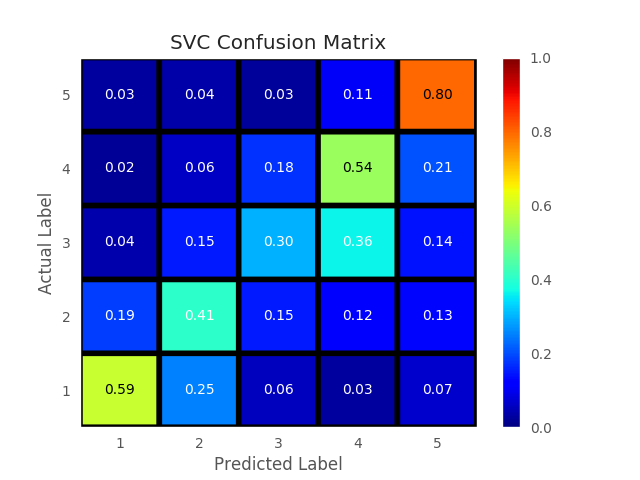

In [25]:
random_forest_vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, 
                                           ngram_range = (1,1), strip_accents = 'unicode', max_features = 1000)

random_forest_feature_matrix_train = random_forest_vectorizer.fit_transform(train_x)
random_forest_feature_matrix_test = random_forest_vectorizer.transform(test_x)
svc_feature_matrix_train = random_forest_feature_matrix_train
svc_feature_matrix_test = random_forest_feature_matrix_test

svc = SVC()
svc.fit(svc_feature_matrix_train, train_y)
svc_predictions = svc.predict(svc_feature_matrix_test)
svc_confusion_matrix = confusion_matrix(test_y, svc_predictions)
plot_confusion_matrix(svc_confusion_matrix, 'SVC Confusion Matrix')

In [22]:
print_classifier_performance_metrics('SVC', svc_predictions)

MODEL: SVC

Precision: 0.520279289001
Recall: [ 0.59        0.40547264  0.3         0.53689567  0.79753086]
F1: [ 0.63101604  0.42614379  0.35087719  0.49299065  0.68215417]
Accuracy: 0.5265

Classification Report:
             precision    recall  f1-score   support

     1 star       0.68      0.59      0.63       400
     2 star       0.45      0.41      0.43       402
     3 star       0.42      0.30      0.35       400
     4 star       0.46      0.54      0.49       393
     5 star       0.60      0.80      0.68       405

avg / total       0.52      0.53      0.52      2000


Precision variance: 0.049448

Recall variance: 0.143547


<h4>Originally the SVM is used for classifying binary problems. However, multi-class problems can be solved by using the one-against-one method. Simply put, this method constructs $k(k-1)/2$ classifiers (if $k$ classes in total), where each classifier is trained on the data from two classes. For training data from the $i$th class and the $j$th class, a binary classification problem is solved. If the solution to the optimization problem says the data point in the $i$ class, then the vote for the $i$th class is added by one. Otherwise, the $j$th is increased by one.The classification of each data point results from the vote of all classifiers.</h4>

<h4>The diagonal entries of the above confusion matrix shows the accuracy of the classification. Noticeably, 5-star rating has the highest accuracy. Given the methodology employed in the SVM, this happens because 5-star rating has the most reviews, leading the algorithm to weigh more in 5-star ratings.</h4>